In [121]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## 1. 어떻게 만들까? 사진 준비하기

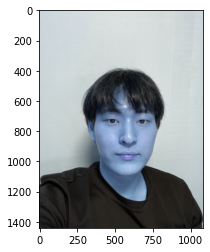

In [122]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/pic.jpg'
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr)
plt.show()

opencv는 예외적으로 BGR을 사용하기 때문에 원본 사진에서 붉은색은 푸른색으로, 푸른색은 붉은색으로 바뀌어 출력되었다.

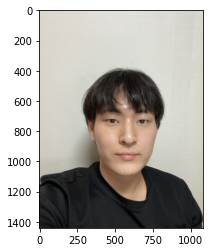

In [123]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

원래 색깔로 보정.

## 2. 얼굴 검출 face detection

In [124]:
detector_hog = dlib.get_frontal_face_detector()

디텍터 선언.

In [125]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

detector_hog를 이용해서 얼굴의 bounding box를 추출

rectangles[[(348, 605) (810, 1067)]]


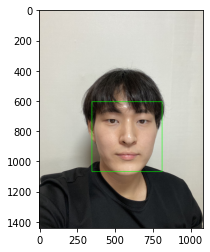

In [126]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

dlib은 rgb 이미지를 입력으로 받기 때문에 cvtColor() 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환

## 3. 얼굴 랜드마크 face landmark

In [127]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

Landmark 모델 불러오기

landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환

In [128]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장

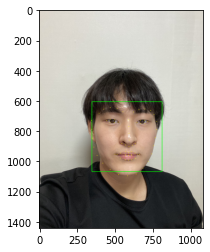

In [129]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

 얼굴 랜드마크가 이미지에 정확히 출력됨.
 
 (노드보다 노란색 점들이 훨씬 희미해서 확대해서 봐야한다.)

## 4. 스티커 적용하기

In [130]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[8]) # 코의 index는 8 입니다
    x = landmark[8][0]
    y = landmark[8][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(583, 1095)
(x,y) : (583,864)
(w,h) : (463,463)


(463, 463, 3)


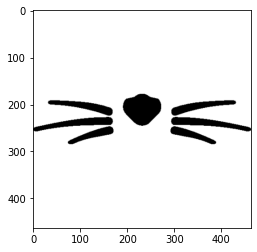

In [131]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다
img_sticker = cv2.resize(img_sticker, (w,h))
plt.imshow(img_sticker)
print (img_sticker.shape)

In [132]:
# lefttop 이동
refined_x = x - w // 2
refined_y = y - h // 2


print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (352,633)


In [133]:
# 원본 이미지에 스티커를 적용 
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

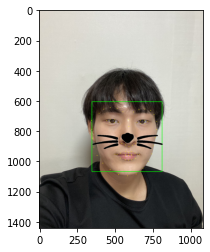

In [134]:
# 결과 이미지 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

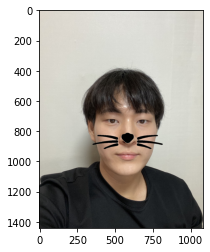

In [135]:
# 원본 이미지에 스티커를 적용 
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 회고

고양이 수염이 코에 위치하지 않고 다른 곳(이마, 머리 위 등)에 있어서 위치 잡는데 시간이 걸렸다.<br>
디텍터로 바운딩박스 설정하고 얼굴 랜드마크 추출도 잘 됐는데 왜 수염 위치는 엉뚱한데 가서 붙을까??<br>
코 인덱스가 30인데 나는 8로 설정했더니 코로 가서 달라 붙었다.. 8은 턱인데...<br>
개인적으로 CV가 더 어려운 느낌. 코드가 정신이 없고 간단한 사진 작업도 시간이 오래걸린다..  <br>
자연어가 차분히 집중해서 뚝심있게 하기 더 나은듯한 너낌적인 너낌.. 데이터톤도 자연어로!! <br>
시간이 없어서 다른사진 적용은 포기..<br>

여기서 주어진 기본 모델만으로 이미 바운딩박스 랜드마크 추출이 정확하게 가능하단게 놀랍고<br> 한 2015년쯤만 해도 중국산 카메라 어플이 조잡스럽기 그지 없다고 느꼈었는데(ㅋㅋ) 그 사이 발전이 대단하다는 새삼스런 생각~~..